In [57]:
#Simulation for grid

In [58]:
import csv
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt

In [59]:
fileName='01-04-2020-TO-01-04-2021RELIANCEALLN.csv'

In [60]:
#Remaining cash
remCash=200000
#Current stock quanity
currStocks=0
#trade quanitiy
tQ=10
#Grid gap 
gG=10
#Number of Grids on each side
nG=5
#Orders
orders=[]
#Past orders
pastOrders=[]
#Reference price. To decide buy vs sell
rP=2000
#lower limit
gL=rP-gG*nG
#upper limit
gU=rP+gG*nG

In [61]:
data=[]
with open(fileName) as f:
    reader=csv.DictReader(f)
    for rows in reader:
        data.append(rows)
        
#Parse date
for d in data[1:]:
    d['Date']=datetime.strptime(d['Date'],"%d-%b-%Y")

In [62]:
dataStart=min([row['Date'] for row in data[1:]])
dataEnd=max([row['Date'] for row in data[1:]])
print(f'Data startDate={dataStart} and endDate={dataEnd}')
#Analysis range
startDate=datetime(2021,1,1)
endDate=datetime(2021,6,1)
#filter data for required range
targetData=list(filter(lambda x:x['Date']>startDate and x['Date']<endDate,data[1:]))

Data startDate=2020-04-03 00:00:00 and endDate=2021-04-01 00:00:00


In [63]:
def float_range(start, stop, step):
  while start < stop:
    yield float(start)
    start += float(step)

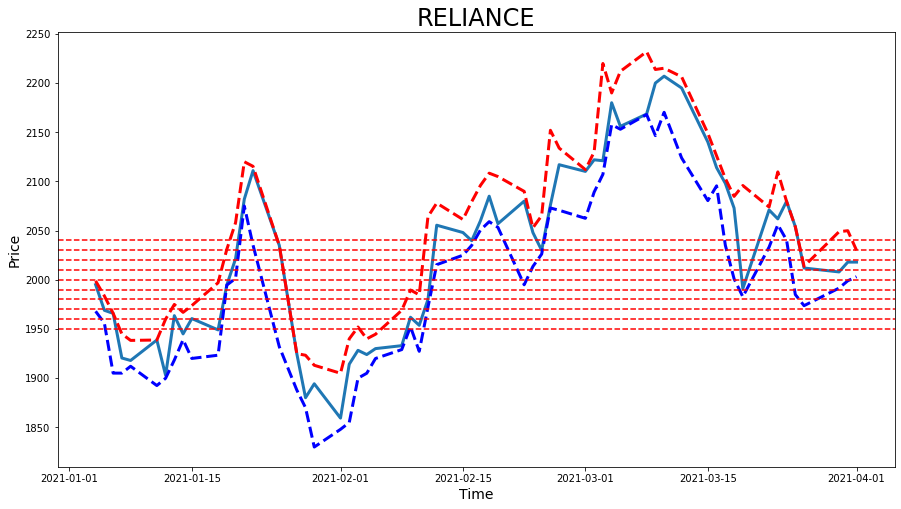

In [64]:
#Data preview
dates=[row['Date'] for row in targetData]
openPrice=[float(row['Open Price']) for row in targetData]
closePrice=[float(row['Close Price']) for row in targetData]

highPrice=[float(row['High Price']) for row in targetData]
lowPrice=[float(row['Low Price']) for row in targetData]

x=dates
y=openPrice

fig,ax=plt.subplots()
fig.set_size_inches(15, 8)
ax.set_title(data[0]['Symbol'],fontsize=24)
ax.set_xlabel('Time',fontsize=14)
ax.set_ylabel('Price',fontsize=14)
ax.plot(x,y,linewidth=3)
#ax.plot(x,closePrice,linewidth=3,ls='--')
ax.plot(x,highPrice,linewidth=3,c='red',ls='--')
ax.plot(x,lowPrice,linewidth=3,c='blue',ls='--')
for i in float_range(gL,gU,gG):
    ax.axhline(y=i,c='red',ls='--')

In [65]:
def placeOrders(cP):
    global remCash,currStocks
    if(cP<gL or cP>gU):
        print('Exiting trade as price is outside the grid')
        return
    
    #Put buy orders below current price
    refBuyPrice=gL+((cP-gL)//gG)*gG
    for i in range(1,2):
        tStamp=datetime.now()
        buyPrice=refBuyPrice-i*gG
        if(buyPrice<gL):
            print(f'Exiting trade as range is outside the grid @ {datetime.now()}')
            return
        cashRequired=tQ*buyPrice
        print(f'gridMatchPrice={refBuyPrice} buyPrice={buyPrice} cashRequired={cashRequired} @{tStamp}')
        if(remCash>cashRequired):
            orders.append({'type':'BUY','quantity':tQ,'price':buyPrice,'timeStamp':str(tStamp)})
            remCash=remCash-cashRequired
            print(f'Added buy @{buyPrice} remainingCash={remCash} @{tStamp}')
        else:
            print(f'Out of cash for lot buy. Cash left={remCash} @{tStamp}')

    #Put sell orders above current price 
    if(currStocks<tQ):
        print(f'Exiting as not enough stocks to trade. currentStocks={currStocks} @ {datetime.now()}')
        return
    refSellPrice=gU-((gU-cP)//gG)*gG
    
    for i in range(1,2):
        tStamp=datetime.now()
        sellPrice=refSellPrice+i*gG
        if(sellPrice>gU):
            print(f'Exiting trade as range is outside the grid @ {datetime.now()}')
            return
        potentialEarnings=tQ*sellPrice
        print(f'gridMatchPrice={refSellPrice} sellPrice={sellPrice} *earnings={potentialEarnings} @{tStamp}')
        if(currStocks>=tQ):
            orders.append({'type':'SELL','quantity':tQ,'price':sellPrice,'timeStamp':str(tStamp)})
            currStocks=currStocks-tQ
            print(f'Added sell @{sellPrice} remainingStocks={currStocks} @{tStamp}')
        else:
            print(f'Waiting as less than lot stocks to trade @{tStamp}')

In [66]:
def processOrders(ohlc):
    global remCash,currStocks
    for o in orders:
        if(o.get('status','')=='Executed'):
            return
        tradePrice=o['price']
        quantity=o['quantity']
        orderType=o['type']
        if(tradePrice>=float(ohlc['Low Price']) and tradePrice<=float(ohlc['High Price'])):
            o['status']='Executed'
            if(orderType=='BUY'):
                currStocks=currStocks+quantity
            else:
                currStocks=currStocks-quantity
                remCash=remCash+tradePrice*quantity
            print(f'Order type={orderType} processed for price={tradePrice}')
        else:
            print(f'Order type={orderType} for price={tradePrice} not processed')

In [67]:
def clearPendingOrders():
    global remCash,currStocks,orders,pastOrders
    for o in orders:
        #pastOrders.append(o)
        if(o.get('status','')!='Executed'):
            if(o['type']=='BUY'):
                remCash=remCash+o['quantity']*o['price']
            else:
                currStocks=currStocks+o['quantity']
    orders=[]

In [68]:
def getTrades(b,s,status):
    for i,po in enumerate(pastOrders):
        for o in po:
            if o.get('status','')==status:
                continue
            if(o.get('type','')=='BUY'):
                b.append((i,o['price']))
            else:
                s.append((i,o.get('price',0)))


In [69]:
#Run on prices
for i,o in enumerate(targetData,start=1):
    placeOrders(float(o['Open Price']))
    processOrders(o)
    #processOrders({'Low':o['Low'],'High':o['High']})
    pastOrders.append(orders)
    clearPendingOrders()
    #print(f'{i} in {o}')

gridMatchPrice=1990.0 buyPrice=1980.0 cashRequired=19800.0 @2021-06-02 21:26:49.964475
Added buy @1980.0 remainingCash=180200.0 @2021-06-02 21:26:49.964475
Exiting as not enough stocks to trade. currentStocks=0 @ 2021-06-02 21:26:49.964794
Order type=BUY processed for price=1980.0
gridMatchPrice=1960.0 buyPrice=1950.0 cashRequired=19500.0 @2021-06-02 21:26:49.964830
Added buy @1950.0 remainingCash=160700.0 @2021-06-02 21:26:49.964830
gridMatchPrice=1970.0 sellPrice=1980.0 *earnings=19800.0 @2021-06-02 21:26:49.964951
Added sell @1980.0 remainingStocks=0 @2021-06-02 21:26:49.964951
Order type=BUY for price=1950.0 not processed
Order type=SELL processed for price=1980.0
gridMatchPrice=1960.0 buyPrice=1950.0 cashRequired=19500.0 @2021-06-02 21:26:49.965006
Added buy @1950.0 remainingCash=180500.0 @2021-06-02 21:26:49.965006
Exiting as not enough stocks to trade. currentStocks=-10 @ 2021-06-02 21:26:49.965036
Order type=BUY processed for price=1950.0
Exiting trade as price is outside the g

In [70]:
def showRun():
    #bot buy \ sell orders
    bo=[]
    so=[]
    getTrades(bo,so,'')

    #trade buy \ sell executions
    tb=[]
    ts=[]
    getTrades(tb,ts,'Executed')

    fig,ax=plt.subplots()
    fig.set_size_inches(15, 8)
    x=dates
    y=openPrice
    ax.set_title(targetData[0]['Symbol'],fontsize=24)
    ax.set_xlabel('Time',fontsize=14)
    ax.set_ylabel('Price',fontsize=14)
    td=timedelta(hours=1)
    for b in bo:
        ax.scatter(dates[b[0]] - td,b[1],c='orange',alpha=1,s=200)
    for s in so:
        ax.scatter(dates[s[0]] + td,s[1],marker='^',c='blue',alpha=1,s=200)

    for b in tb:
        ax.scatter(dates[b[0]],b[1],c='green',alpha=1,s=200)
    for s in ts:
        ax.scatter(dates[s[0]],s[1],marker='^',c='red',alpha=1,s=200)    

    ax.plot(x,y,linewidth=3)
    for i in float_range(gL,gU,gG):
        ax.axhline(y=i,c='grey',ls='dotted')

    #add legend
    plt.scatter([], [], c='orange',s=200,label='Bot buy bid')    
    plt.scatter([], [], c='blue', marker='^',s=200,label='Bot sell bid')    
    plt.scatter([], [], c='green', s=200,label='Buy executed')    
    plt.scatter([], [], c='red', marker='^',s=200,label='Sell executed')    
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Legend')
    ax.plot(x,highPrice,linewidth=3,c='pink',ls='--')
    ax.plot(x,lowPrice,linewidth=3,c='blue',ls='--')
    #ax.tick_params(axis='x', rotation=30)

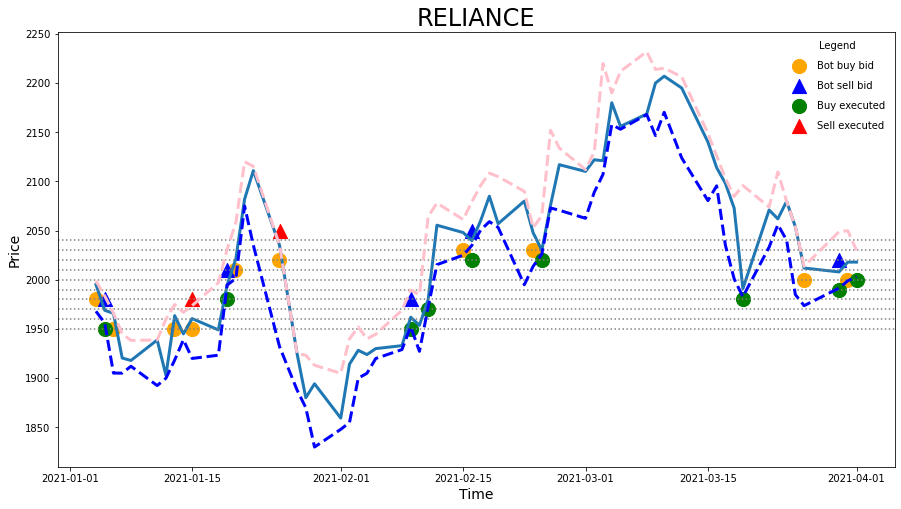

In [71]:
showRun()

In [72]:
b=0
s=0
for o in all_orders:
    value=o['price']*o['quantity']
    if o['type']=='BUY':
        b=b+value
    else:
        s=s+value
print(f'buy={b} sell={s}')
b-s

buy=199200.0 sell=100400.0


98800.0

In [73]:
from pandas import DataFrame
df=DataFrame(all_orders)
df[['type','quantity','price']]

,type,quantity,price
0,BUY,10,1980.0
1,SELL,10,1980.0
2,BUY,10,1950.0
3,BUY,10,1950.0
4,BUY,10,1950.0
5,SELL,10,2010.0
6,BUY,10,2010.0
7,BUY,10,2020.0
8,SELL,10,1980.0
9,BUY,10,2030.0
